#  Mentor-Mentee Topic Matching on the Enron email dataset

The goal of this notebook is to ...

In [2]:
%load_ext autoreload
import re, os
import json

workdir = "/Users/Andrea/Documents/Education/ULB/Phd/Github/PMI-case-study/"
dirMail = str(workdir)  + "data/enron/maildir/"
dirCode = str(workdir)  + "code/"
dirRes = str(workdir)  + "res/"

os.chdir(dirCode)
from preprocessing import *
%reload_ext preprocessing


We will look at the "sent" directory of each of the 150 employees of Enron. We need to import the data and in turn, clean up the data. Info from [here](https://rforwork.info/2013/11/03/a-rather-nosy-topic-model-analysis-of-the-enron-email-corpus/) and here [here](https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html) proved to be very useful. Also see http://www.colorado.edu/ics/sites/default/files/attached-files/01-11_0.pdf 
We now build a list of strings - each string being an email (document). Each document is filtered according to some regular expressions. We also build a dictionary, namely, user_docs_dict that stores for each iteration of a user, the corresponding name and as well as a list of the filtered emails.

In [5]:
# For each user we extract all the emails in their inbox
users = [i for i in os.listdir(dirMail)]

'''
user_docs_list = [] # Stores email sender's name and content
for user in users:
    sent =  str(dirMail) + str(user) + '/sent'   
    try: 
        os.chdir(sent)
        d = []
        for email in os.listdir():          
            text = open(email,'r').read()
            # Regular 'clutter' from each email
            text = remove_unwanted_text(text)
            d.append(text)
        user_docs_list.append((user, d))
    except:
        pass
    
user_docs_dict = dict(user_docs_list)

# Save the user_docs_dict file as json
with open(dirRes + 'user_docs_dict.jsn','w') as f:
    json.dump(user_docs_dict,f)
f.close()

'''

"\nuser_docs_list = [] # Stores email sender's name and content\nfor user in users:\n    sent =  str(dirmail) + str(user) + '/sent'   \n    try: \n        os.chdir(sent)\n        d = []\n        for email in os.listdir():          \n            text = open(email,'r').read()\n            # Regular 'clutter' from each email\n            text = remove_unwanted_text(text)\n            d.append(text)\n        user_docs_list.append((user, d))\n    except:\n        pass\n    \nuser_docs_dict = dict(user_docs_list)\n\n# Save the user_docs_dict file as json\nwith open('user_docs_dict.jsn','w') as f:\n    json.dump(user_docs_dict,f)\nf.close()\n\n"

In [65]:

# Loading the user_docs_dict file
with open(dirRes + 'user_docs_dict.jsn','r') as f:
    user_docs_dict = json.load(f)
f.close()


## Let's check how many user and emails are available

In [66]:
num_users = len(user_docs_dict.keys())
print("Total number of users:", num_users)

Total number of users: 88


In [67]:
import numpy as np
import pandas as pd

users = list(user_docs_dict.keys())
num_emails = np.zeros(num_users)
for i in range(num_users):
    u = users[i]
    user_docs = user_docs_dict[u]
    num_emails[i] = len(user_docs)
    
users_df = pd.DataFrame({'users': users, 'num_emails': num_emails})
users_df = users_df.sort_values('num_emails', ascending=False)
users_df.head(10)

,num_emails,users
51,4440.0,mann-k
74,3930.0,dasovich-j
82,3810.0,jones-t
70,3774.0,shackleton-s
43,3463.0,kaminski-v
19,2116.0,germany-c
15,1992.0,lenhart-m
66,1862.0,taylor-m
59,1770.0,perlingiere-d
13,1632.0,sanders-r


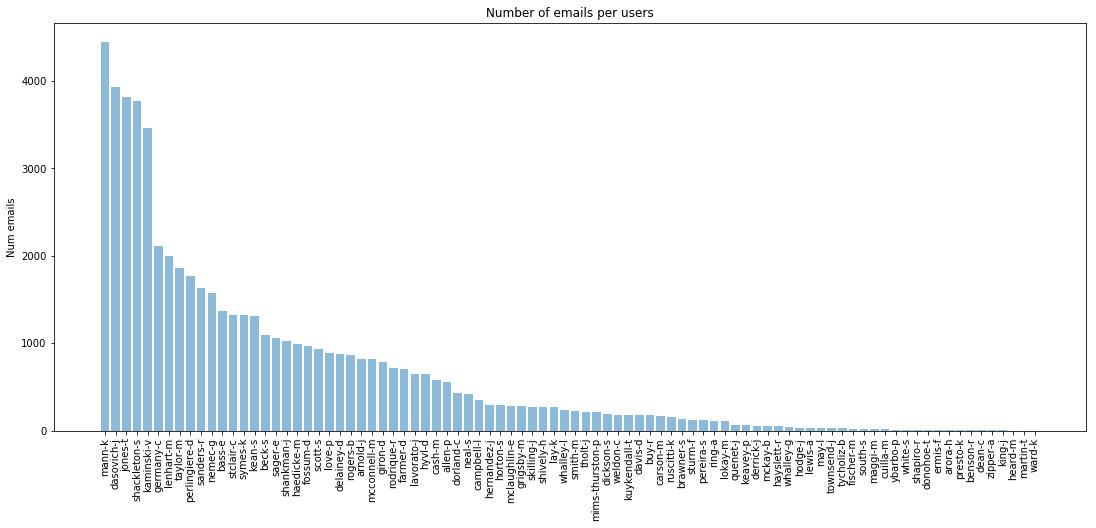

In [68]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(18.5, 7.5)

y_pos = np.arange(num_users)
plt.bar(y_pos, users_df.num_emails, align='center', alpha=0.5)
plt.xticks(y_pos, users_df.users, rotation=90)
plt.ylabel('Num emails')
plt.title('Number of emails per users')

fig.savefig(dirRes+'num_emails.pdf', dpi=100)
#plt.savefig(dirRes+"num_emails.pdf")
plt.show()

In [70]:
#Select a subset of user to speed up the computation
import random
num_sample = 15
#sub_users = [list(user_docs_dict.keys())[i] for i in random.sample(range(num_users), num_sample)] # select randomly
sub_users = list(users_df.users.head(num_sample)) # select users with highest number of emails


# create a new dictionary
user_docs_dict = { user: user_docs_dict[user] for user in sub_users }

users = list(user_docs_dict.keys())
num_users = len(user_docs_dict.keys())

## Topic Modeling: extract major topics in the emails

Now we extract tokens, by removing stop words and using a lemmatizer (see preprocessing.py for a more detaileds).
While creating a new 'texts' variable that stores the filtered documents, we also edit the docs_num_dict to update the words according to the tokenize,stop word, lemmatize procedure.

In [71]:
# store all email content into a list
from collections import defaultdict

user_token_list = []
texts = []
for i in range(num_users):
    user = users[i]
    user_docs = user_docs_dict[user]
    tokens_list = []
    for doc in user_docs:
        tokens = get_token(doc)
        texts.append(tokens)
        tokens_list.append(tokens)
        
    user_token_list.append((user, tokens_list))

user_token_dict = dict(user_token_list)

The texts file is saved.

In [72]:
os.chdir(dirRes)

# Save the texts file as texts_raw (will be edited again below)
with open('texts.jsn','w') as f:
    json.dump(texts,f)
f.close()

'''
os.chdir(dirRes)

# Loading the raw texts file
with open('texts_raw.jsn','r') as f:
    texts = json.load(f)
f.close()
    
'''

"\nos.chdir(dirLDA)\n\n# Loading the raw texts file\nwith open('texts_raw.jsn','r') as f:\n    texts = json.load(f)\nf.close()\n    \n"

Now we construct the document term matrix whereafter the fairly lengthy process of constructing the model takes place.

In [73]:
# Constructing a document-term matrix

from gensim import corpora, models

dictionary = corpora.Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]


In [74]:
num_topics=10
num_passes=10

In [75]:
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=num_passes)

We save both the LDA data as well as the results. We can reanalyse later. See the folder called LDAdata.

In [76]:
os.chdir(dirRes)

# Saving the dictionary
dictionary.save('dictionary')

# Saving the corpus    
with open('corpus.jsn','w') as f:
    json.dump(corpus,f)    
f.close()

# Saving the ldamodel
ldamodel.save('ldamodel')

In [77]:
'''
# Load dictionary
dictionary = corpora.Dictionary.load('dictionary')
ldamodel = models.LdaModel.load('ldamodel') 
# Load corpus
with open('corpus.jsn','r') as f:
    corpus = json.load(f)
f.close()
'''

"\n# Load dictionary\ndictionary = corpora.Dictionary.load('dictionary')\nldamodel = models.LdaModel.load('ldamodel') \n# Load corpus\nwith open('corpus.jsn','r') as f:\n    corpus = json.load(f)\nf.close()\n"

We now print the words for each of the given topics. It must be noted, that even though considerable emphasis has been placed on the construction of the regular expressions, 'junk-text' may be present.

In [78]:
num_words = 7
topic_list = ldamodel.print_topics(num_topics, num_words)

def get_word_topics(topic_num, topic_list):
    word_list = re.sub(r'(.\....\*)|(\+ .\....\*)', '', topic_list[topic_num][1])
    words = [word for word in word_list.split()]
    return(words)
    
Topic_words =[]
for i in range(0, num_topics):
    words = get_word_topics(i, topic_list)    
    Topic_words.append(words)

idx = ['Topic'+str(i+1) for i in range(num_topics)]
labels = ['Word'+str(i+1) for i in range(num_words)]
Topics_df = pd.DataFrame.from_records(Topic_words, columns=labels, index=idx)
Topics_df

,Word1,Word2,Word3,Word4,Word5,Word6,Word7
Topic1,"""deal""","""let""","""need""","""best""","""jeff""","""question""","""make"""
Topic2,"""deal""","""contract""","""price""","""gas""","""day""","""term""","""volume"""
Topic3,"""going""","""good""","""day""","""way""","""work""","""weekend""","""let"""
Topic4,"""power""","""california""","""state""","""energy""","""utility""","""market""","""company"""
Topic5,"""company""","""trading""","""product""","""new""","""service""","""enron""","""trade"""
Topic6,"""enron""","""agreement""","""713""","""attached""","""corp""","""north""","""america"""
Topic7,"""gerald""","""game""","""carol""","""year""","""zone""","""play""","""texas"""
Topic8,"""message""","""mail""","""information""","""intended""","""received""","""email""","""copy"""
Topic9,"""fuel""","""western""","""creek""","""joseph""","""tax""","""county""","""703"""
Topic10,"""meeting""","""let""","""enron""","""number""","""conference""","""day""","""friday"""


## Define Mentor's expertise on each topic

In [79]:
def text_likelihood_per_topic(texts, ldamodel, num_topics):

    score = np.zeros(num_topics)
    
    for text in texts:
        #ldamodel output : [(id1, score1), (id2, score2),... if id != 0]
        for topic_id, topic_lik in ldamodel[dictionary.doc2bow(text)]:
            # returns each topic and the likelihood that the query relates to that topic. 
            # Gensim defaults to only showing the top ones that meet a certain threshold (>= 0.01)
            score[topic_id] += topic_lik
   
    # score is the sum of likelihood on each topic
    # we normalize the score
    norm_score = score/np.sum(score)
    
    return norm_score 


In [80]:
user_expertise = np.zeros((num_users, num_topics))
for i in range(num_users):
    user = users[i]
    token_list = user_token_dict[user]
    user_score = text_likelihood_per_topic(token_list, ldamodel, num_topics)
    user_expertise[i,:] = user_score

user_expertise

cols = ['Topic'+str(i+1) for i in range(num_topics)]
expertise_df = pd.DataFrame.from_records(user_expertise, columns=cols, index=users)
expertise_df

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10
bass-e,0.095345,0.064725,0.308883,0.040211,0.085514,0.080674,0.146609,0.034866,0.031689,0.111484
mann-k,0.142800,0.098015,0.156890,0.047988,0.023971,0.283317,0.029010,0.098738,0.023282,0.095989
kaminski-v,0.167776,0.046964,0.130706,0.117421,0.200275,0.059017,0.036802,0.032498,0.034186,0.174357
stclair-c,0.142706,0.093688,0.074360,0.027213,0.033400,0.371706,0.101453,0.040489,0.012466,0.102518
sanders-r,0.177548,0.099036,0.102917,0.100529,0.037453,0.139803,0.033523,0.155081,0.029515,0.124594
taylor-m,0.140849,0.103174,0.125928,0.064563,0.107451,0.221360,0.033245,0.051309,0.020109,0.132012
kean-s,0.246787,0.069360,0.072410,0.252043,0.085578,0.064312,0.030066,0.033555,0.023753,0.122136
shackleton-s,0.104267,0.075104,0.049155,0.034126,0.060366,0.483542,0.021166,0.051124,0.013388,0.107763
jones-t,0.092478,0.068299,0.083888,0.040327,0.095322,0.470206,0.029394,0.025923,0.018110,0.076052
perlingiere-d,0.016925,0.030546,0.037169,0.014430,0.011999,0.830749,0.009463,0.009762,0.008185,0.030772


In [81]:
# check that row sum is zero for each user
np.sum(user_expertise, axis=1)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.])

In [82]:
#average user_expertise
np.mean(user_expertise)

0.10000000000000001

In [83]:
avg_expertise_per_topic = expertise_df.mean(axis=0)
avg_expertise_per_topic

Topic1     0.146894
Topic2     0.099081
Topic3     0.148012
Topic4     0.076170
Topic5     0.064799
Topic6     0.238226
Topic7     0.054387
Topic8     0.046803
Topic9     0.025214
Topic10    0.100413
dtype: float64

## Mentor-Mentee matching

We now have a method to see which topics are prevalent for a given user (Mentor).
Let's simulate the topic preference of a new employee (Mentee).

In [84]:
r = np.random.rand(1,num_topics) # vector of random number between 0 and 1
#normalize to have sum = 1 (like a probability)
nr = r/np.sum(r)
mentee_pref = nr
mentee_pref

array([[ 0.11901012,  0.1057691 ,  0.13062597,  0.01209501,  0.09333203,
         0.0761486 ,  0.08891645,  0.13010045,  0.14526844,  0.09873383]])

Let's assume that the mentee has access to the topics and provides his/her preference on each topic.
We can reccomend an expert (Mentors) based on the mentee's preference using a distance measure (e.g. minimizing Euclidea distance). For the sake of semplicity we will compute similarity using the Euclidea distance. Alternativelly, one could use Minkowski distance, Pearson correlation, Cosine similarity, L2 Norm... 

In [85]:
def dist(X, y):   
    return np.sqrt(np.sum((X-y)**2, axis=1))

d = dist(user_expertise, mentee_pref)

expert_match = list(np.array(users)[d == min(d)])
expert_match

['sanders-r']

Let's assume instead the mentee selects the words he/she is interested in based on the words appearing among all topics

In [86]:
# let's take some words randomly across different topics
flat_list = [word for sublist in Topic_words for word in sublist]
flat_list = [x.replace('"', '') for x in flat_list]
words_sample = [flat_list[i] for i in random.sample(range(len(flat_list)), num_words)]
words_sample

['county', 'message', 'attached', 'need', 'enron', 'good', 'best']

In [87]:
#let's compute the relevance of each word for all topics

def word_likelihood_per_topic(word, ldamodel, num_topics):
    
    word_likelihood = np.zeros(num_topics)
    term_topics = ldamodel.get_term_topics(word) #Returns most likely topics for a particular word
    if term_topics:
        for topic_tuple in term_topics:
            topic_id = topic_tuple[0]
            topic_lik = topic_tuple[1] #likelihood
            word_likelihood[topic_id] = topic_lik
    
    return(word_likelihood)


word_likelihoods = np.zeros((num_topics, num_words))
for j in range(num_words):
    w = word_likelihood_per_topic(words_sample[j], ldamodel, num_topics)
    word_likelihoods[:,j] = w
    

idx = ['Topic'+str(i+1) for i in range(num_topics)]
labels = ['Word'+str(i+1) for i in range(num_words)]
word_like_df = pd.DataFrame.from_records(word_likelihoods, columns=labels, index=idx)
word_like_df

,Word1,Word2,Word3,Word4,Word5,Word6,Word7
Topic1,0.0,0.00000,0.000000,0.016153,0.000000,0.000000,0.011833
Topic2,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Topic3,0.0,0.00000,0.000000,0.000000,0.000000,0.011962,0.000000
Topic4,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Topic5,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Topic6,0.0,0.00000,0.018943,0.000000,0.028397,0.000000,0.000000
Topic7,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Topic8,0.0,0.03307,0.000000,0.000000,0.000000,0.000000,0.000000
Topic9,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
Topic10,0.0,0.00000,0.000000,0.000000,0.011225,0.000000,0.000000


We use a technique from content-based reccomendaiton systems: recommend item based on a similarity comparison between the content (words) of the items (Topic) and a user’s profile (Mentor's expertise).
We match the mentor by computing the dot product between then word-topic likelihood and the user-topic likelihood. 
The user corrisponding to the largest values is the one with is more likely to have more knolodge about the words queried.

In [88]:
W = np.dot(user_expertise, word_likelihoods)
usermax = np.argmax(W, axis=1)

match_prob = usermax/np.sum(usermax)
list(np.array(users)[match_prob == max(match_prob)])

['bass-e', 'lenhart-m']

# Performance evalutation

Let's assume that we want to have a 1-1 Match, i.e. only one Mentor per Mentee.
In a random match each Mentor has equal probability to be selected.
The best match is achieved when one Mentor has probability to be selected equal to one and the others zero.
The worst match occurs when all Mentors have zero probability to be selected as the expert.

In [105]:
#uniform matching (all mentors have the same preference)
unif_match = np.ones(num_topics)/num_topics
#random matching
rdm_match = np.array(random.sample(range(num_topics), num_topics))
rdm_match = rdm_match/np.sum(rdm_match)
#best matching 
worst_match = np.zeros(num_topics)
#best matching 
best_match = np.zeros(num_topics)
best_match[random.sample(range(num_topics), 1)] = 1


# consider using Kurtosis

def acc(x):
    N = len(x)
    maxScore = 1/N * (N-1) + (1-1/N)
    score = np.sum(np.abs(x - np.mean(x)))
    return score/maxScore 
    
print("uniform accuracy", acc(unif_match), "random accuracy", acc(rdm_match), "worst accuracy", acc(worst_match), 
      "best accuracy", acc(best_match), " our accuracy", acc(match_prob))

uniform accuracy 0.0 random accuracy 0.308641975309 worst accuracy 0.0 best accuracy 1.0  our accuracy 0.0508474576271


In [108]:
def acc2(x):
    score = np.max(x) 
    return score

print("uniform accuracy", acc(unif_match), "random accuracy", acc(rdm_match), "worst accuracy", acc2(worst_match), 
      "best accuracy", acc2(best_match), " our accuracy", acc2(match_prob))

uniform accuracy 0.0 random accuracy 13.8888888889 worst accuracy -3.0 best accuracy 5.111111111111111  our accuracy -0.0010956902848788808


# Extra
Can we predict the Mentor's expertise on a single topic? Maybe, to test this hyphotesis we should use the target topic as independent variable, the remaining topics as feature and solve a regression problem. Given the relatively small number of email users I think the accuracy of such model should be rather low.

# Check K-means and PCA projection

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

flat_texts = [text for text in texts]
text_sample = [flat_texts[i] for i in random.sample(range(len(flat_texts)), 1000)]

wordvector = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.4, min_df=5)
wordvector_fit = wordvector.fit_transform(text_sample)
feature = wordvector.get_feature_names()

AttributeError: 'list' object has no attribute 'lower'

In [59]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

N = 4
clf = KMeans(n_clusters=N, 
            max_iter=50, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(wordvector_fit)


wordvector_fit_2d = wordvector_fit.todense()
pca = PCA(n_components=2).fit(wordvector_fit_2d)
datapoint = pca.transform(wordvector_fit_2d)


label = ["#e05f14", "#e0dc14", "#2fe014", "#14d2e0"]
color = [label[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

NameError: name 'wordvector_fit' is not defined